# 1. Setup

Use GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the Git repo. 

In [31]:
!rm -rf /content/Diffusion
%cd /content




/content


In [32]:
!git clone -b fix/dataloader-phys --single-branch https://github.com/Riccardo582/Diffusion.git
%cd Diffusion/


Cloning into 'Diffusion'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 270 (delta 154), reused 209 (delta 93), pack-reused 0 (from 0)
Receiving objects: 100% (270/270), 4.96 MiB | 11.60 MiB/s, done.
Resolving deltas: 100% (154/154), done.
/content/Diffusion


In [11]:
!ls
import os, sys
os.chdir("Diffusion")
sys.path.append(os.getcwd())


#pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT ,DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

# Sample from Pre-trained DiT Models (For reference)

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [ ]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

*Verify number of GPU available*

In [18]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())


CUDA available: True
GPU count: 1


**Run the model**

In [ ]:
!torchrun --nnodes=1 --nproc_per_node=1 train.py \
  --model DiT-S/2 \
  --data-path data/datasets/data/darcy_train_16.pt \
  --ckpt-every 800 \
  --image-size 16 \
  --cx 1 \
  --cy 1 \
  --epochs 50 \
  --global-batch-size 8 \
  --num-workers 2


*Plot error curve*

checkpoints  log.txt
Parsed 12 points from results/000-DiT-S-2/log.txt


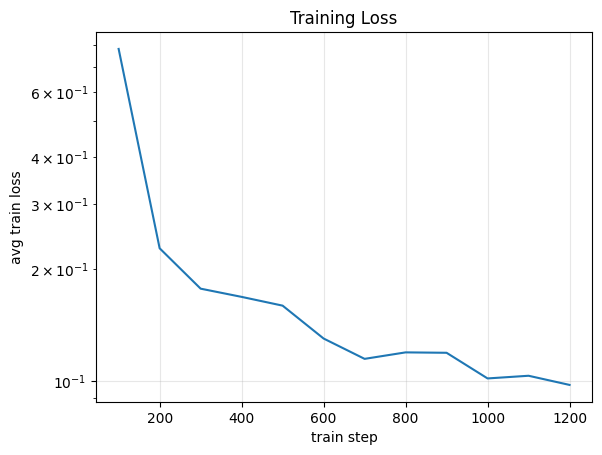

In [34]:

import re
import matplotlib.pyplot as plt

!ls results/000-DiT-S-2

LOG = "results/000-DiT-S-2/log.txt"  

steps, loss = [], []
pat = re.compile(r"\(step=(\d+)\)\s+Train Loss:\s+([0-9.]+)")

with open(LOG, "r") as f:
    for line in f:
        m = pat.search(line)
        if m:
            steps.append(int(m.group(1)))
            loss.append(float(m.group(2)))

print(f"Parsed {len(loss)} points from {LOG}")
if len(loss) == 0:
    raise SystemExit("No loss lines found. Check LOG path or log format")

plt.figure()
plt.semilogy(steps, loss)
plt.xlabel("train step")
plt.ylabel("avg train loss")
plt.title("Training Loss")
plt.grid(alpha=0.3)
plt.show()



Sample from the trained model


In [ ]:
!torchrun --nproc_per_node=1 sample_ddp.py \
  --model DiT-S/2 \
  --dataset-pt data/datasets/data/darcy_train_16.pt \
  --ckpt results/000-DiT-S-2/checkpoints/0001000.pt \
  --H 16 --W 16 --cx 1 --cy 1 \
  --per-proc-batch-size 8 \
  --num-fid-samples 64 \
  --sample-dir samples_pde

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)
Starting rank=0, seed=0, world_size=1.
loaded: ema
/usr/local/lib/python3.12/dist-packages/torch/distributed/distributed_c10d.py:4876: UserWarning: barrier(): using the device under current context. You can specify `device_id` in `init_process_group` to mute this warning.
  warnings.warn(  # warn only once
[rank0]:[W213 15:24:08.511109052 ProcessGroupNCCL.cpp:5068] Guessi

In [50]:
%ls results/000-DiT-S-2/checkpoints/

0001000.pt


In [14]:
import numpy as np

path = "samples_pde/samples_rank0000.npz"
d = np.load(path)

# list keys
print("keys:", d.files)

# shapes and data types
for k in d.files:
    v = d[k]
    print(f"{k:10s}  shape={v.shape}  dtype={v.dtype}")

for k in ("H","W","cx","cy","seed","model","ckpt"):
    if k in d.files:
        v = d[k]
        try:
            print(k, v.item())
        except Exception:
            print(k, v)



keys: ['x_cond', 'y_true', 'y_sample', 'H', 'W', 'cx', 'cy', 'model', 'ckpt', 'seed']
x_cond      shape=(64, 1, 16, 16)  dtype=float32
y_true      shape=(64, 1, 16, 16)  dtype=float32
y_sample    shape=(64, 1, 16, 16)  dtype=float32
H           shape=()  dtype=int64
W           shape=()  dtype=int64
cx          shape=()  dtype=int64
cy          shape=()  dtype=int64
model       shape=()  dtype=<U7
ckpt        shape=()  dtype=<U42
seed        shape=()  dtype=int64
H 16
W 16
cx 1
cy 1
seed 0
model DiT-S/2
ckpt results/000-DiT-S-2/checkpoints/0001000.pt


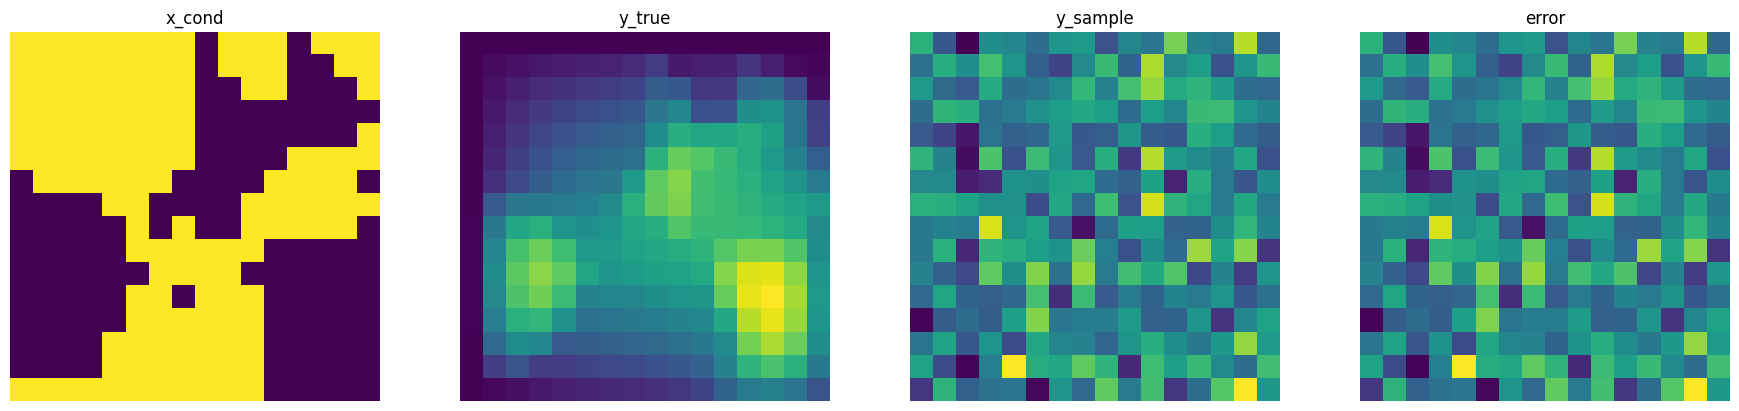

In [15]:

d = np.load(path)
x = d["x_cond"]      # (N,Cx,H,W)
yt = d.get("y_true") # (N,Cy,H,W) or missing
ys = d["y_sample"]   # (N,Cy,H,W)

i = 0
cx = 0
cy = 0

fig, ax = plt.subplots(1, 4 if yt is not None else 2, figsize=(18,4), constrained_layout=True)

ax[0].imshow(x[i, cx]); ax[0].set_title("x_cond"); ax[0].axis("off")
if yt is not None:
    ax[1].imshow(yt[i, cy]); ax[1].set_title("y_true"); ax[1].axis("off")
    ax[2].imshow(ys[i, cy]); ax[2].set_title("y_sample"); ax[2].axis("off")
    ax[3].imshow(ys[i, cy] - yt[i, cy]); ax[3].set_title("error"); ax[3].axis("off")
else:
    ax[1].imshow(ys[i, cy]); ax[1].set_title("y_sample"); ax[1].axis("off")

plt.show()


In [67]:
import numpy as np

yt = d["y_true"]
ys = d["y_sample"]
mse = ((ys - yt)**2).mean()
rel = np.sqrt(((ys-yt)**2).mean()) / (np.sqrt((yt**2).mean()) + 1e-12)
print("MSE:", mse, "relative RMSE:", rel)
print("y_true mean/std:", yt.mean(), yt.std())
print("y_samp mean/std:", ys.mean(), ys.std())
print("error mean/std:", (ys-yt).mean(), (ys-yt).std())


MSE: 0.8352964 relative RMSE: 1.7344651
y_true mean/std: 0.39739603 0.34602585
y_samp mean/std: -0.0032093152 0.74612534
error mean/std: -0.40060532 0.8214693
